# start

from 0320_3; tune separate models

In [4]:
PRFX='0320_6'
trntmstmp=1584412344
valtmstmp=1584806233
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])


['2020-03-17 02:32:24', '2020-03-21 15:57:13']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']


# setup

In [5]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [6]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
# langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [7]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    
    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm
        
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour
    
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    
    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age
    
    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

#     for lang in langs:
#         df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', ])        
    return df

In [8]:
grand_total

150000000.0

In [9]:
grand_total/1e6

150.0

In [10]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=0: break



2020-03-21 01:52:09 chunk 0


In [11]:
df = pd.concat(lst_df)

In [12]:
df.shape

(1000000, 29)

In [13]:
df.columns

Index(['u1_fllwer_cnt', 'u1_fllwng_cnt', 'u1_vrfed', 'u2_fllwer_cnt',
       'u2_fllwng_cnt', 'u2_vrfed', 'u1_fllw_u2', 'len_toks',
       'has_media_Photo', 'has_media_Video', 'has_media_GIF', 'num_hshtgs',
       'num_links', 'num_domns', 'twt_age', 'u1_age', 'u2_age', 'tm_dayofweek',
       'tm_hour', 'tmdlta_u2u1', 'u1_fllwer_cnt_by_age',
       'u1_fllwng_cnt_by_age', 'twttyp_TopLevel', 'twttyp_Retweet',
       'twttyp_Quote', 'retwt', 'reply', 'like', 'retwt_cmmnt'],
      dtype='object')

In [14]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [15]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df[cols_tgt ][:split],df[cols_tgt ][split:]

CPU times: user 171 ms, sys: 181 ms, total: 352 ms
Wall time: 351 ms


In [16]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((850000, 25), (150000, 25), (850000, 4), (150000, 4))

# model

In [30]:
tgt2params = {k:{'objective': 'binary:logistic',
    'verbosity': 2,
    'eval_metric': ['error', 'logloss', 'auc', 'aucpr',],
    'max_delta_step': 1,
} for k in tgts}
tgt2params['Retweet']['max_depth']=5
tgt2params['Reply']['max_depth']=8
tgt2params['Like']['eta']=0.4
tgt2params

{'Retweet': {'objective': 'binary:logistic',
  'verbosity': 2,
  'eval_metric': ['error', 'logloss', 'auc', 'aucpr'],
  'max_delta_step': 1,
  'max_depth': 5},
 'Reply': {'objective': 'binary:logistic',
  'verbosity': 2,
  'eval_metric': ['error', 'logloss', 'auc', 'aucpr'],
  'max_delta_step': 1,
  'max_depth': 8},
 'Like': {'objective': 'binary:logistic',
  'verbosity': 2,
  'eval_metric': ['error', 'logloss', 'auc', 'aucpr'],
  'max_delta_step': 1,
  'eta': 0.4},
 'RTwCmnt': {'objective': 'binary:logistic',
  'verbosity': 2,
  'eval_metric': ['error', 'logloss', 'auc', 'aucpr'],
  'max_delta_step': 1}}

In [31]:
tgt2nrounds = {'Retweet': 200, 'Reply': 100, 'Like': 1000, 'RTwCmnt': 100}

In [32]:
tgt2bst={}
tgt2ytr={}
tgt2yvl={}
tgt2evalres={}
for i,tgt in enumerate(tgts):
    evals_result = {}
    print(dtnow(), tgt, '*'*80)
    tgt2ytr[tgt]=ytr.iloc[:,i]
    tgt2yvl[tgt]=yvl.iloc[:,i]
    params = tgt2params[tgt]
    nrounds = tgt2nrounds[tgt]
    dtr = xgb.DMatrix(Xtr, label=ytr.iloc[:,i], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=yvl.iloc[:,i], feature_names=cols_feat)
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=nrounds, 
                    evals=evallist, evals_result=evals_result, early_stopping_rounds=10)
    tgt2bst[tgt] = bst
    tgt2evalres[tgt] = evals_result
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-21 02:07:19 Retweet ********************************************************************************
[02:07:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-error:0.11288	train-logloss:0.58843	train-auc:0.51176	train-aucpr:0.13160	eval-error:0.11348	eval-logloss:0.58842	eval-auc:0.51057	eval-aucpr:0.12943
Multiple eval metrics have been passed: 'eval-aucpr' will be used for early stopping.

Will train until eval-aucpr hasn't improved in 10 rounds.
[02:07:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-error:0.11287	train-logloss:0.50529	train-auc:0.52228	train-aucpr:0.14524	eval-error:0.11350	eval-logloss:0.50568	eval-auc:0.52164	eval-aucpr:0.14227
[02:07:24] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[2]	train-error:0.11294	train-logloss:0.44343	train-auc:0.57819	tr

[02:07:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[29]	train-error:0.11244	train-logloss:0.32311	train-auc:0.71032	train-aucpr:0.25532	eval-error:0.11313	eval-logloss:0.32564	eval-auc:0.70446	eval-aucpr:0.24593
[02:07:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[30]	train-error:0.11242	train-logloss:0.32293	train-auc:0.71074	train-aucpr:0.25595	eval-error:0.11309	eval-logloss:0.32550	eval-auc:0.70475	eval-aucpr:0.24648
[02:07:44] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[31]	train-error:0.11237	train-logloss:0.32284	train-auc:0.71095	train-aucpr:0.25655	eval-error:0.11307	eval-logloss:0.32543	eval-auc:0.70490	eval-aucpr:0.24701
[02:07:45] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[32]	train-error:0.11236	train-loglos

[02:08:04] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[59]	train-error:0.11200	train-logloss:0.31948	train-auc:0.72050	train-aucpr:0.27054	eval-error:0.11301	eval-logloss:0.32358	eval-auc:0.71006	eval-aucpr:0.25398
[02:08:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[60]	train-error:0.11199	train-logloss:0.31937	train-auc:0.72081	train-aucpr:0.27097	eval-error:0.11303	eval-logloss:0.32353	eval-auc:0.71016	eval-aucpr:0.25422
[02:08:06] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[61]	train-error:0.11196	train-logloss:0.31922	train-auc:0.72122	train-aucpr:0.27158	eval-error:0.11297	eval-logloss:0.32342	eval-auc:0.71049	eval-aucpr:0.25459
[02:08:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[62]	train-error:0.11195	train-loglos

[02:08:26] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[89]	train-error:0.11167	train-logloss:0.31726	train-auc:0.72664	train-aucpr:0.28087	eval-error:0.11296	eval-logloss:0.32296	eval-auc:0.71161	eval-aucpr:0.25625
[02:08:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[90]	train-error:0.11166	train-logloss:0.31724	train-auc:0.72667	train-aucpr:0.28100	eval-error:0.11298	eval-logloss:0.32296	eval-auc:0.71160	eval-aucpr:0.25625
[02:08:27] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[91]	train-error:0.11166	train-logloss:0.31720	train-auc:0.72676	train-aucpr:0.28123	eval-error:0.11299	eval-logloss:0.32296	eval-auc:0.71159	eval-aucpr:0.25626
[02:08:28] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[92]	train-error:0.11161	train-loglos

[02:08:47] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[119]	train-error:0.11128	train-logloss:0.31543	train-auc:0.73155	train-aucpr:0.29014	eval-error:0.11276	eval-logloss:0.32260	eval-auc:0.71232	eval-aucpr:0.25830
[02:08:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=5
[120]	train-error:0.11128	train-logloss:0.31542	train-auc:0.73158	train-aucpr:0.29019	eval-error:0.11275	eval-logloss:0.32261	eval-auc:0.71228	eval-aucpr:0.25828
[02:08:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[121]	train-error:0.11127	train-logloss:0.31534	train-auc:0.73186	train-aucpr:0.29054	eval-error:0.11274	eval-logloss:0.32261	eval-auc:0.71228	eval-aucpr:0.25830
[02:08:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[122]	train-error:0.11127	train-lo

[02:09:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[149]	train-error:0.11105	train-logloss:0.31400	train-auc:0.73559	train-aucpr:0.29669	eval-error:0.11271	eval-logloss:0.32241	eval-auc:0.71293	eval-aucpr:0.25938
[02:09:09] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=5
[150]	train-error:0.11105	train-logloss:0.31399	train-auc:0.73561	train-aucpr:0.29683	eval-error:0.11273	eval-logloss:0.32242	eval-auc:0.71291	eval-aucpr:0.25925
[02:09:10] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[151]	train-error:0.11105	train-logloss:0.31397	train-auc:0.73567	train-aucpr:0.29691	eval-error:0.11273	eval-logloss:0.32243	eval-auc:0.71289	eval-aucpr:0.25926
[02:09:11] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 44 extra nodes, 0 pruned nodes, max_depth=5
[152]	train-error:0.11102	train-lo

[02:09:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[179]	train-error:0.11075	train-logloss:0.31201	train-auc:0.74106	train-aucpr:0.30595	eval-error:0.11269	eval-logloss:0.32201	eval-auc:0.71424	eval-aucpr:0.26070
[02:09:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=5
[180]	train-error:0.11075	train-logloss:0.31197	train-auc:0.74120	train-aucpr:0.30614	eval-error:0.11267	eval-logloss:0.32203	eval-auc:0.71420	eval-aucpr:0.26064
[02:09:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=5
[181]	train-error:0.11074	train-logloss:0.31191	train-auc:0.74134	train-aucpr:0.30642	eval-error:0.11267	eval-logloss:0.32203	eval-auc:0.71418	eval-aucpr:0.26058
[02:09:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=5
[182]	train-error:0.11074	train-lo

[02:09:59] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=8
[17]	train-error:0.02773	train-logloss:0.11133	train-auc:0.79017	train-aucpr:0.13285	eval-error:0.02715	eval-logloss:0.11343	eval-auc:0.75617	eval-aucpr:0.07897
[02:10:00] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=8
[18]	train-error:0.02773	train-logloss:0.11086	train-auc:0.79268	train-aucpr:0.13440	eval-error:0.02715	eval-logloss:0.11322	eval-auc:0.75674	eval-aucpr:0.07921
[02:10:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=8
[19]	train-error:0.02773	train-logloss:0.11052	train-auc:0.79430	train-aucpr:0.13559	eval-error:0.02715	eval-logloss:0.11314	eval-auc:0.75682	eval-aucpr:0.07913
[02:10:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=8
[20]	train-error:0.02772	train-lo

[02:10:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=8
[47]	train-error:0.02766	train-logloss:0.10586	train-auc:0.82523	train-aucpr:0.18308	eval-error:0.02717	eval-logloss:0.11289	eval-auc:0.75901	eval-aucpr:0.08146
[02:10:33] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=8
[48]	train-error:0.02766	train-logloss:0.10580	train-auc:0.82554	train-aucpr:0.18408	eval-error:0.02718	eval-logloss:0.11288	eval-auc:0.75915	eval-aucpr:0.08140
[02:10:34] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=8
[49]	train-error:0.02766	train-logloss:0.10576	train-auc:0.82574	train-aucpr:0.18448	eval-error:0.02718	eval-logloss:0.11288	eval-auc:0.75921	eval-aucpr:0.08150
[02:10:35] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=8
[50]	train-error:0.02766	train-log

[02:11:02] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[13]	train-error:0.32828	train-logloss:0.60616	train-auc:0.72367	train-aucpr:0.66425	eval-error:0.33351	eval-logloss:0.60992	eval-auc:0.71744	eval-aucpr:0.65613
[02:11:03] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[14]	train-error:0.32763	train-logloss:0.60539	train-auc:0.72460	train-aucpr:0.66537	eval-error:0.33284	eval-logloss:0.60937	eval-auc:0.71810	eval-aucpr:0.65689
[02:11:04] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[15]	train-error:0.32680	train-logloss:0.60450	train-auc:0.72565	train-aucpr:0.66690	eval-error:0.33205	eval-logloss:0.60850	eval-auc:0.71915	eval-aucpr:0.65855
[02:11:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[16]	train-error:0.32548	train-log

[42]	train-error:0.31829	train-logloss:0.59389	train-auc:0.73815	train-aucpr:0.68325	eval-error:0.32661	eval-logloss:0.60100	eval-auc:0.72809	eval-aucpr:0.67083
[02:11:29] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[43]	train-error:0.31823	train-logloss:0.59382	train-auc:0.73824	train-aucpr:0.68336	eval-error:0.32660	eval-logloss:0.60095	eval-auc:0.72816	eval-aucpr:0.67086
[02:11:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=6
[44]	train-error:0.31812	train-logloss:0.59367	train-auc:0.73840	train-aucpr:0.68355	eval-error:0.32639	eval-logloss:0.60084	eval-auc:0.72829	eval-aucpr:0.67098
[02:11:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=6
[45]	train-error:0.31799	train-logloss:0.59349	train-auc:0.73861	train-aucpr:0.68380	eval-error:0.32625	eval-logloss:0.60079	eval-auc:0.72836	eval-aucpr:0.67

[02:11:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
[72]	train-error:0.31349	train-logloss:0.58790	train-auc:0.74505	train-aucpr:0.69176	eval-error:0.32319	eval-logloss:0.59765	eval-auc:0.73204	eval-aucpr:0.67557
[02:11:55] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=6
[73]	train-error:0.31340	train-logloss:0.58764	train-auc:0.74535	train-aucpr:0.69214	eval-error:0.32297	eval-logloss:0.59750	eval-auc:0.73222	eval-aucpr:0.67575
[02:11:56] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=6
[74]	train-error:0.31325	train-logloss:0.58745	train-auc:0.74559	train-aucpr:0.69251	eval-error:0.32318	eval-logloss:0.59750	eval-auc:0.73220	eval-aucpr:0.67580
[02:11:57] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[75]	train-error:0.31304	train-lo

[101]	train-error:0.30937	train-logloss:0.58292	train-auc:0.75087	train-aucpr:0.69923	eval-error:0.32144	eval-logloss:0.59552	eval-auc:0.73449	eval-aucpr:0.67859
[02:12:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[102]	train-error:0.30921	train-logloss:0.58276	train-auc:0.75106	train-aucpr:0.69948	eval-error:0.32145	eval-logloss:0.59549	eval-auc:0.73452	eval-aucpr:0.67866
[02:12:22] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[103]	train-error:0.30905	train-logloss:0.58260	train-auc:0.75126	train-aucpr:0.69974	eval-error:0.32138	eval-logloss:0.59543	eval-auc:0.73458	eval-aucpr:0.67878
[02:12:23] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[104]	train-error:0.30899	train-logloss:0.58254	train-auc:0.75134	train-aucpr:0.69982	eval-error:0.32139	eval-logloss:0.59545	eval-auc:0.73455	eval-aucpr

[02:12:48] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=6
[131]	train-error:0.30629	train-logloss:0.57881	train-auc:0.75563	train-aucpr:0.70543	eval-error:0.32043	eval-logloss:0.59429	eval-auc:0.73599	eval-aucpr:0.68053
[02:12:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[132]	train-error:0.30624	train-logloss:0.57876	train-auc:0.75570	train-aucpr:0.70550	eval-error:0.32046	eval-logloss:0.59431	eval-auc:0.73598	eval-aucpr:0.68049
[02:12:49] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[133]	train-error:0.30620	train-logloss:0.57865	train-auc:0.75578	train-aucpr:0.70564	eval-error:0.32042	eval-logloss:0.59424	eval-auc:0.73604	eval-aucpr:0.68057
[02:12:50] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=6
[134]	train-error:0.30611	train-l

[160]	train-error:0.30337	train-logloss:0.57534	train-auc:0.75961	train-aucpr:0.71096	eval-error:0.31965	eval-logloss:0.59313	eval-auc:0.73736	eval-aucpr:0.68211
[02:13:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=6
[161]	train-error:0.30330	train-logloss:0.57526	train-auc:0.75971	train-aucpr:0.71106	eval-error:0.31967	eval-logloss:0.59315	eval-auc:0.73734	eval-aucpr:0.68210
[02:13:15] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=6
[162]	train-error:0.30308	train-logloss:0.57501	train-auc:0.75998	train-aucpr:0.71135	eval-error:0.31951	eval-logloss:0.59296	eval-auc:0.73757	eval-aucpr:0.68227
[02:13:16] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=6
[163]	train-error:0.30295	train-logloss:0.57490	train-auc:0.76013	train-aucpr:0.71158	eval-error:0.31957	eval-logloss:0.59296	eval-auc:0.73757	eval-aucpr

[02:13:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[190]	train-error:0.29982	train-logloss:0.57124	train-auc:0.76438	train-aucpr:0.71679	eval-error:0.31797	eval-logloss:0.59199	eval-auc:0.73873	eval-aucpr:0.68359
[02:13:41] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=6
[191]	train-error:0.29972	train-logloss:0.57105	train-auc:0.76459	train-aucpr:0.71704	eval-error:0.31785	eval-logloss:0.59184	eval-auc:0.73891	eval-aucpr:0.68381
[02:13:42] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[192]	train-error:0.29959	train-logloss:0.57090	train-auc:0.76478	train-aucpr:0.71720	eval-error:0.31801	eval-logloss:0.59185	eval-auc:0.73891	eval-aucpr:0.68380
[02:13:43] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=6
[193]	train-error:0.29940	train

[02:14:05] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[7]	train-error:0.00778	train-logloss:0.10557	train-auc:0.54253	train-aucpr:0.01520	eval-error:0.00759	eval-logloss:0.10515	eval-auc:0.54246	eval-aucpr:0.01014
[02:14:06] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[8]	train-error:0.00778	train-logloss:0.08636	train-auc:0.63147	train-aucpr:0.02223	eval-error:0.00759	eval-logloss:0.08601	eval-auc:0.61288	eval-aucpr:0.01297
[02:14:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[9]	train-error:0.00778	train-logloss:0.07279	train-auc:0.66259	train-aucpr:0.02491	eval-error:0.00759	eval-logloss:0.07241	eval-auc:0.64795	eval-aucpr:0.01356
[02:14:08] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=6
[10]	train-error:0.00778	train-loglos

[02:14:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[37]	train-error:0.00778	train-logloss:0.04180	train-auc:0.75804	train-aucpr:0.05239	eval-error:0.00759	eval-logloss:0.04310	eval-auc:0.67351	eval-aucpr:0.01636
[02:14:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=6
[38]	train-error:0.00777	train-logloss:0.04169	train-auc:0.76126	train-aucpr:0.05429	eval-error:0.00759	eval-logloss:0.04311	eval-auc:0.67348	eval-aucpr:0.01631
[02:14:31] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[39]	train-error:0.00777	train-logloss:0.04165	train-auc:0.76219	train-aucpr:0.05527	eval-error:0.00759	eval-logloss:0.04310	eval-auc:0.67412	eval-aucpr:0.01631
[02:14:32] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[40]	train-error:0.00777	train-loglo

In [34]:
tgt2bst

{'Retweet': <xgboost.core.Booster at 0x7f6b10d84710>,
 'Reply': <xgboost.core.Booster at 0x7f6b1100b0d0>,
 'Like': <xgboost.core.Booster at 0x7f6b1100b910>,
 'RTwCmnt': <xgboost.core.Booster at 0x7f6b10dd8c10>}

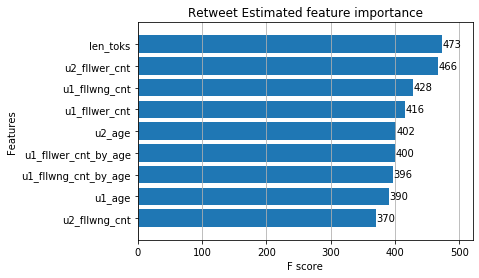

Retweet


,0,1
0,len_toks,473
5,u2_fllwer_cnt,466
6,u1_fllwng_cnt,428
3,u1_fllwer_cnt,416
15,u2_age,402
4,u1_fllwer_cnt_by_age,400
2,u1_fllwng_cnt_by_age,396
12,u1_age,390
1,u2_fllwng_cnt,370
21,twt_age,310


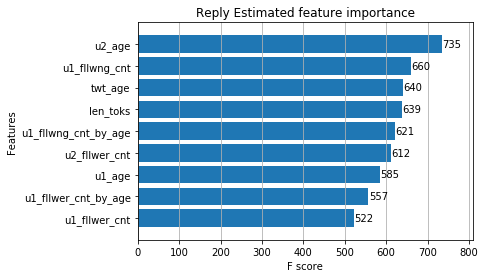

Reply


,0,1
0,u2_age,735
7,u1_fllwng_cnt,660
9,twt_age,640
4,len_toks,639
2,u1_fllwng_cnt_by_age,621
3,u2_fllwer_cnt,612
6,u1_age,585
1,u1_fllwer_cnt_by_age,557
8,u1_fllwer_cnt,522
16,tmdlta_u2u1,509


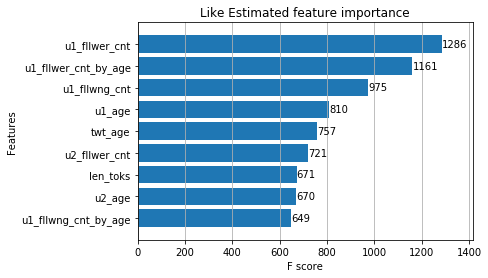

Like


,0,1
5,u1_fllwer_cnt,1286
4,u1_fllwer_cnt_by_age,1161
12,u1_fllwng_cnt,975
6,u1_age,810
11,twt_age,757
9,u2_fllwer_cnt,721
3,len_toks,671
8,u2_age,670
2,u1_fllwng_cnt_by_age,649
10,u2_fllwng_cnt,590


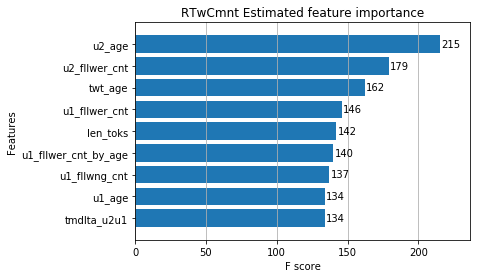

RTwCmnt


,0,1
0,u2_age,215
1,u2_fllwer_cnt,179
10,twt_age,162
3,u1_fllwer_cnt,146
5,len_toks,142
11,u1_fllwer_cnt_by_age,140
9,u1_fllwng_cnt,137
4,tmdlta_u2u1,134
7,u1_age,134
2,u2_fllwng_cnt,118


In [35]:
def show_feat_importance(tgt):
    bst=tgt2bst[tgt]
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    print(tgt)
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20))

for tgt in tgts:
    show_feat_importance(tgt)

## valid

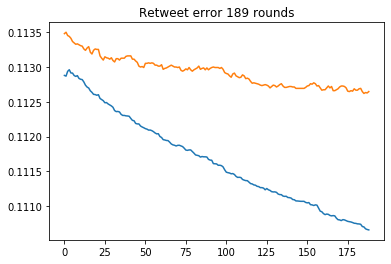

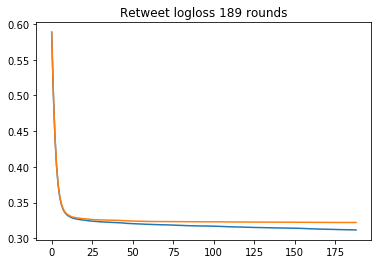

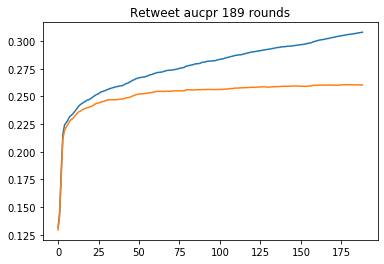

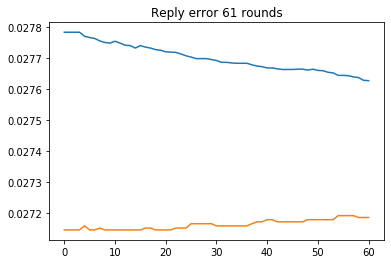

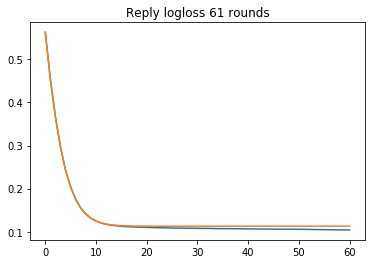

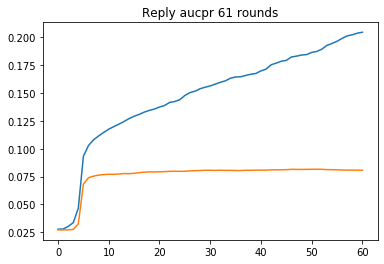

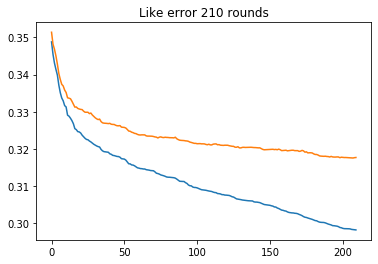

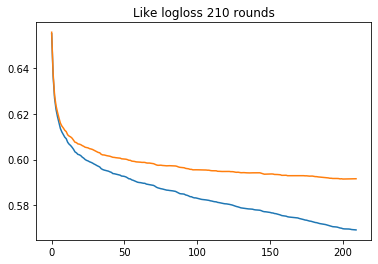

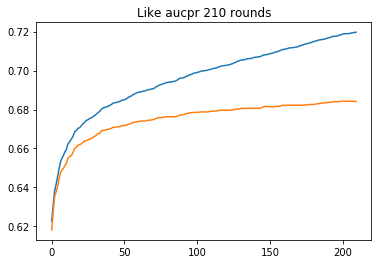

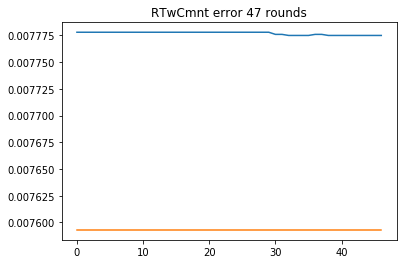

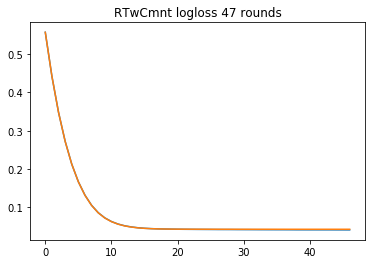

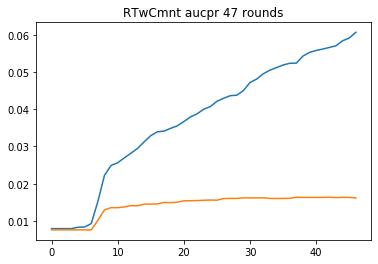

In [37]:
for tgt in tgts:
    evalres=tgt2evalres[tgt]
    plt.plot(evalres['train']['error'])
    plt.plot(evalres['eval']['error'])
    plt.title(f"{tgt} error {len(evalres['train']['error'])} rounds")
    plt.show()
    plt.plot(evalres['train']['logloss'])
    plt.plot(evalres['eval']['logloss'])
    plt.title(f"{tgt} logloss {len(evalres['train']['logloss'])} rounds")
    plt.show()
    plt.plot(evalres['train']['aucpr'])
    plt.plot(evalres['eval']['aucpr'])
    plt.title(f"{tgt} aucpr {len(evalres['train']['aucpr'])} rounds")
    plt.show()
    


In [41]:
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr, ntree_limit=bst.best_ntree_limit)
    tgt2prdvl[tgt] = bst.predict(dvl, ntree_limit=bst.best_ntree_limit)
    

2020-03-21 02:25:00 Retweet
2020-03-21 02:25:01 Reply
2020-03-21 02:25:02 Like
2020-03-21 02:25:03 RTwCmnt


In [42]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7411 valid auc: 0.7142
train prauc: 0.3060 valid auc: 0.2607
train rce: 11.5835 valid rce: 8.9732
Reply
train rocauc: 0.8269 valid auc: 0.7590
train prauc: 0.1873 valid auc: 0.0816
train rce: 16.8505 valid rce: 9.4530
Like
train rocauc: 0.7661 valid auc: 0.7394
train prauc: 0.7188 valid auc: 0.6843
train rce: 16.9070 valid rce: 13.6770
RTwCmnt
train rocauc: 0.7580 valid auc: 0.6735
train prauc: 0.0524 valid auc: 0.0164
train rce: 8.1791 valid rce: 3.4102


In [43]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.305952,11.5835,0.187291,16.8505,0.718776,16.907,0.0523861,8.17912
scrval,0.260703,8.97325,0.0815883,9.45298,0.684302,13.677,0.0163626,3.4102


got worse...

before hand tune:

    metric	PRAUC Retweet	RCE Retweet	PRAUC Reply	RCE Reply	PRAUC Like	RCE Like	PRAUC RTwCmnt	RCE RTwCmnt
    scrtrn	0.325697	12.7221	0.136979	13.9688	0.746328	19.7303	0.0566063	8.62937
    scrval	0.262218	9.095	0.0812799	9.56305	0.692805	14.5781	0.0163491	3.42157

# infer

In [22]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 37s, sys: 8.76 s, total: 1min 46s
Wall time: 1min 46s


In [23]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 47.1 s, sys: 8.17 s, total: 55.3 s
Wall time: 55.3 s


In [24]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-20 16:28:21 Retweet
2020-03-20 16:28:34 Reply
2020-03-20 16:28:39 Like
2020-03-20 16:29:33 RTwCmnt
CPU times: user 19min 49s, sys: 12.8 s, total: 20min 2s
Wall time: 1min 53s


In [25]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [26]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-20 16:29:38 Retweet
2020-03-20 16:30:34 Reply
2020-03-20 16:31:31 Like
2020-03-20 16:32:26 RTwCmnt
CPU times: user 3min 37s, sys: 6.78 s, total: 3min 44s
Wall time: 3min 45s
